In [4]:
import wandb
import wandb
from wandb.keras import WandbCallback
import os
import cv2
import keras.callbacks
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [6]:
#Initial wandb
wandb.init(project="sentinel2-segmentation", entity="koltigis")

In [7]:
# MinMaxScaler
minmaxscaler = MinMaxScaler()

# Dataset path
dataset_root_folder = 'C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet'
dataset_name = 'semantic_segmentation_dataset'

- **for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):** adalah perulangan **for** yang menggunakan **os.walk** untuk menjelajahi setiap direktori dan file yang ada di dalam **dataset_root_folder/dataset_name**
- **dir_name = path.split(os.path.sep)[-1]** yaitu :
**path.split(os.path.sep)** memecah string path menjadi bagian-bagian berdasarkan separator path. Misalnya, jika path adalah **'folder1/folder2/folder3'**, pemisahan tersebut akan menghasilkan list **['folder1', 'folder2', 'folder3']**
**[-1]** digunakan untuk mengakses elemen terakhir dari list yang dihasilkan. Dalam contoh di atas, ini akan menghasilkan 'folder3'
- **if dir_name == 'masks':**  Pernyataan ini memeriksa apakah direktori saat ini memiliki nama 'masks'
- **images = os.listdir(path):** Baris ini mengambil daftar file yang ada dalam direktori saat ini (path)

In [8]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
    dir_name = path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images = os.listdir(path)
        print(path)
        # print(images)
        for i, image_name in enumerate(images):
            if (image_name.endswith('.png')):
                # print(image_name)
                a = True

C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 1\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 2\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 3\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 4\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 5\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_

In [9]:
image_patch_size = 256
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg')
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step= image_patch_size)
image_x = image_patches[0,0,:,:]
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)
image_y.shape

(1, 256, 256, 3)

In [10]:
# from PIL import Image

image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):  # Perbaikan pada dimensi indeks
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            # print(individual_patched_image.shape)
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [11]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


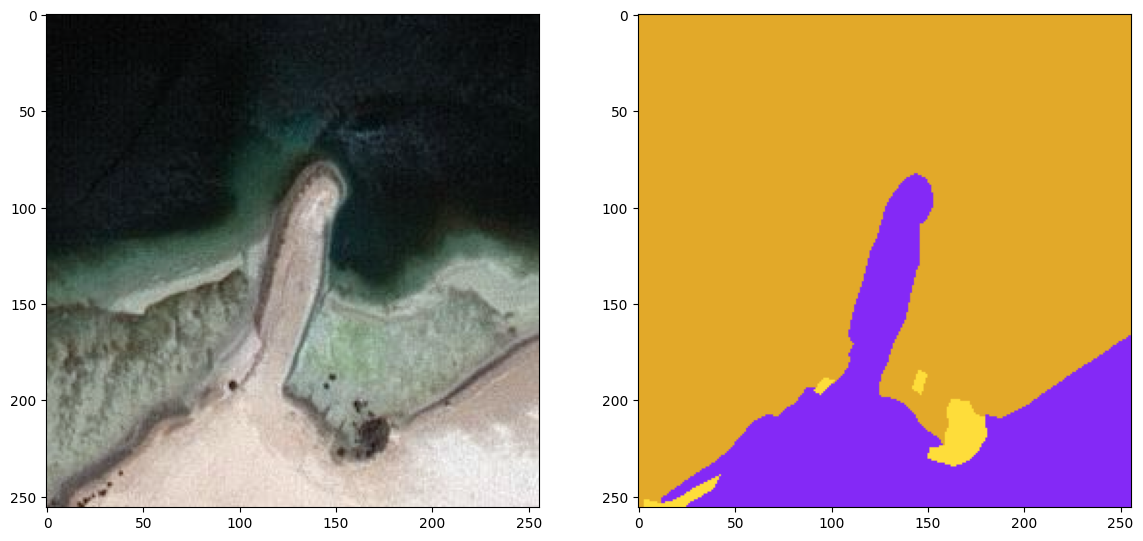

In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [13]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [14]:
label = individual_patched_image
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:,:,0]
    # print(label_segment)
    return label_segment

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [16]:
labels = np.array(labels)
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [17]:
labels = np.expand_dims(labels, axis=3)

In [18]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

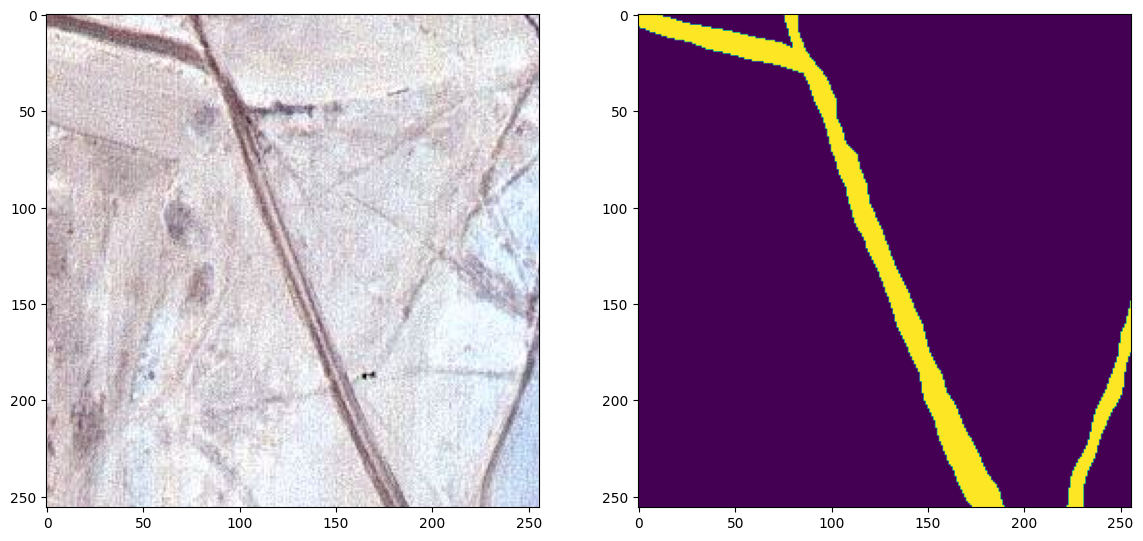

In [19]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

## Split Datasets

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [21]:
total_classes = len(np.unique(labels))
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [22]:
master_training_dataset = image_dataset
master_training_dataset.shape

(945, 256, 256, 3)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


**Output :**
(803, 256, 256, 3) => 803 image, ukuran 256 x 256, 3 band
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6) => 803 mask, ukuran 256 x 256, 6 kelas

In [25]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
image_class = y_train.shape[3]

In [26]:
print(f"Image height : {image_height}")
print(f"Image width : {image_width}")
print(f"Image channels : {image_channels}")
print(f"Image class : {image_class}")

Image height : 256
Image width : 256
Image channels : 3
Image class : 6


## Create IoU -> create model architecture -> Fit the model -> generating loss

In [27]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [28]:
from keras import backend as K

In [29]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [30]:
# Create IoU (Jaccard coefision)
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [31]:
# Create model architecture
def multi_unet_model(n_class=5, image_height=256, image_width=256, image_channels=1):

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_class, (1,1), activation="softmax")(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [32]:
metrics = ["accuracy", jaccard_coef]

In [33]:
def get_deep_learning_model():
    return multi_unet_model(n_class=total_classes,
                            image_height=image_height,
                            image_width=image_width,
                            image_channels=image_channels)

In [34]:
model = get_deep_learning_model()

In [35]:
# Generating loss function
# total_loss = (dice_loss + (1 * focal_loss)
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Model Compilation

In [36]:
import tensorflow as tf
from IPython.display import clear_output
%matplotlib inline

In [37]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [38]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();

plot_loss = PlotLoss()

In [39]:
# wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [40]:
# wandb.config.dropout = 0.2

In [41]:
my_callback_object = WandbCallback()
x_train = np.array(x_train)
y_train = np.array(y_train)

model_history = model.fit(x_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=10,
                          validation_data=(x_test, y_test),
                          callbacks=[my_callback_object],
                          shuffle=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.9989 - accuracy: 0.5899 - jaccard_coef: 0.2743

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.1s


51/51 [==============================] - 328s 6s/step - loss: 0.9989 - accuracy: 0.5899 - jaccard_coef: 0.2743 - val_loss: 0.9890 - val_accuracy: 0.6553 - val_jaccard_coef: 0.3217
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 0.9719 - accuracy: 0.6940 - jaccard_coef: 0.4021

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.1s


51/51 [==============================] - 303s 6s/step - loss: 0.9719 - accuracy: 0.6940 - jaccard_coef: 0.4021 - val_loss: 0.9777 - val_accuracy: 0.6613 - val_jaccard_coef: 0.4671
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.9583 - accuracy: 0.7284 - jaccard_coef: 0.4795

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.1s


51/51 [==============================] - 278s 5s/step - loss: 0.9583 - accuracy: 0.7284 - jaccard_coef: 0.4795 - val_loss: 0.9731 - val_accuracy: 0.6814 - val_jaccard_coef: 0.4588
Epoch 4/10
51/51 [==============================] - 291s 6s/step - loss: 0.9533 - accuracy: 0.7423 - jaccard_coef: 0.5082 - val_loss: 0.9755 - val_accuracy: 0.6853 - val_jaccard_coef: 0.4748
Epoch 5/10
51/51 [==============================] - 296s 6s/step - loss: 0.9484 - accuracy: 0.7553 - jaccard_coef: 0.5281 - val_loss: 0.9754 - val_accuracy: 0.6758 - val_jaccard_coef: 0.4607
Epoch 6/10
51/51 [==============================] - 350s 7s/step - loss: 0.9463 - accuracy: 0.7633 - jaccard_coef: 0.5417 - val_loss: 0.9756 - val_accuracy: 0.6759 - val_jaccard_coef: 0.4538
Epoch 7/10
51/51 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.7777 - jaccard_coef: 0.5679

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.2s


51/51 [==============================] - 335s 7s/step - loss: 0.9414 - accuracy: 0.7777 - jaccard_coef: 0.5679 - val_loss: 0.9712 - val_accuracy: 0.6984 - val_jaccard_coef: 0.4922
Epoch 8/10
51/51 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.7900 - jaccard_coef: 0.5847

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.1s


51/51 [==============================] - 343s 7s/step - loss: 0.9370 - accuracy: 0.7900 - jaccard_coef: 0.5847 - val_loss: 0.9683 - val_accuracy: 0.7089 - val_jaccard_coef: 0.5175
Epoch 9/10
51/51 [==============================] - ETA: 0s - loss: 0.9335 - accuracy: 0.8011 - jaccard_coef: 0.6047

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.2s


51/51 [==============================] - 374s 7s/step - loss: 0.9335 - accuracy: 0.8011 - jaccard_coef: 0.6047 - val_loss: 0.9668 - val_accuracy: 0.7202 - val_jaccard_coef: 0.5308
Epoch 10/10
51/51 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.8103 - jaccard_coef: 0.6193

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230616_092059-pmo8zyld\files\model-best)... Done. 0.2s


51/51 [==============================] - 339s 7s/step - loss: 0.9300 - accuracy: 0.8103 - jaccard_coef: 0.6193 - val_loss: 0.9659 - val_accuracy: 0.7260 - val_jaccard_coef: 0.5457


In [42]:
history_a = model_history

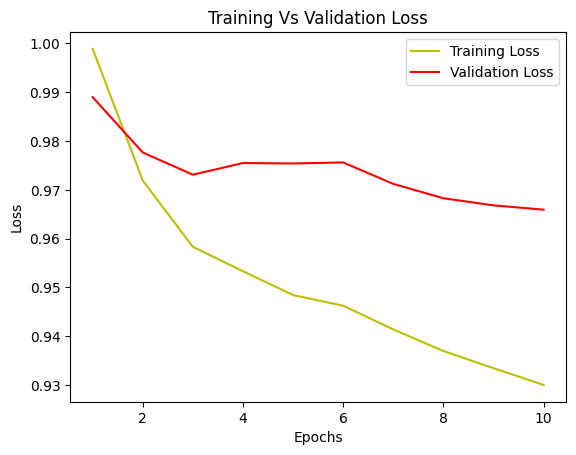

In [43]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

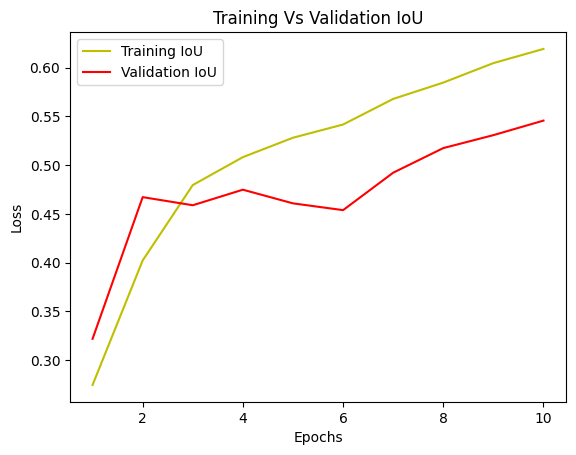

In [44]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [45]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [46]:
y_pred = model.predict(x_test)

5/5 [==============================] - 8s 1s/step


In [47]:
len(y_pred)

142

In [51]:
y_pred

array([[[[1.14607789e-01, 3.92247021e-01, 1.92615375e-01,
          7.73787722e-02, 1.39910206e-01, 8.32408220e-02],
         [5.54804727e-02, 4.67965543e-01, 2.38317475e-01,
          7.50116184e-02, 1.32040709e-01, 3.11842114e-02],
         [3.86610962e-02, 5.72489798e-01, 1.86465099e-01,
          5.30267172e-02, 1.19539067e-01, 2.98181511e-02],
         ...,
         [5.42613305e-02, 3.38956952e-01, 3.07674408e-01,
          6.52718246e-02, 1.86364114e-01, 4.74713892e-02],
         [6.49025738e-02, 3.31340760e-01, 2.78606713e-01,
          7.09124357e-02, 2.02033341e-01, 5.22040538e-02],
         [8.70109126e-02, 2.59101033e-01, 2.74707198e-01,
          8.75539333e-02, 2.09433481e-01, 8.21935460e-02]],

        [[4.28666174e-02, 5.53415596e-01, 2.27124453e-01,
          5.97691834e-02, 8.10577124e-02, 3.57665010e-02],
         [8.57509300e-03, 5.86772144e-01, 2.73276865e-01,
          7.68186748e-02, 3.84461582e-02, 1.61111075e-02],
         [5.35133295e-03, 6.68230593e-01, 2.4038

In [48]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [49]:
len(y_pred_argmax)

142

In [50]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]],

       [[4, 4, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [4, 2, 2, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2],
        [4, 4, 4, ..., 2, 2, 2]],

       ...,

       [[4, 4, 4, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [52]:
y_test_argmax = np.argmax(y_test, axis=3)

In [53]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Perbandingan antara mask ground truth dan mask predicted

In [54]:
import random

In [56]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 95ms/step


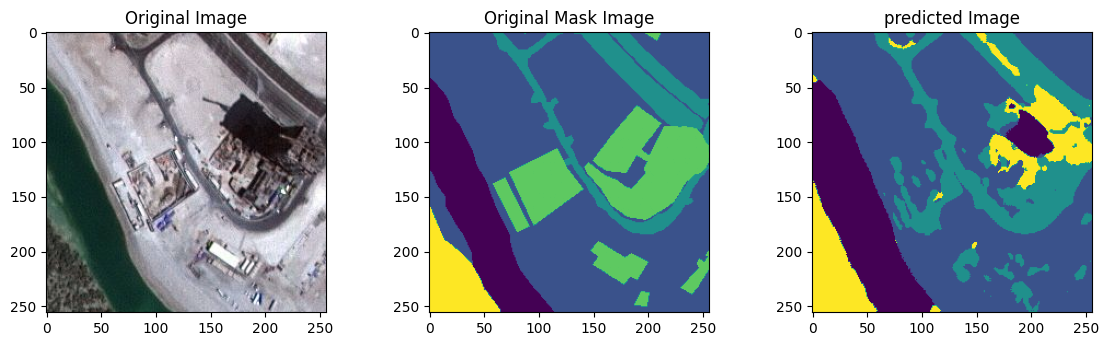

In [58]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Mask Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image)

## Save dan reload model dengan memodifikasi loss

In [59]:
model.save("satellite_segmentation_full.h5")

In [60]:
from keras.models import load_model

In [61]:
#load model
saved_model = load_model(
    'C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/satellite_segmentation_full.h5',
    custom_objects=({'dice_loss_plus_1focal_loss' : total_loss, 'jaccard_coef': jaccard_coef})
)

In [62]:
#perform model
test_image_number = random.randint(0, len(x_test))
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = saved_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 456ms/step


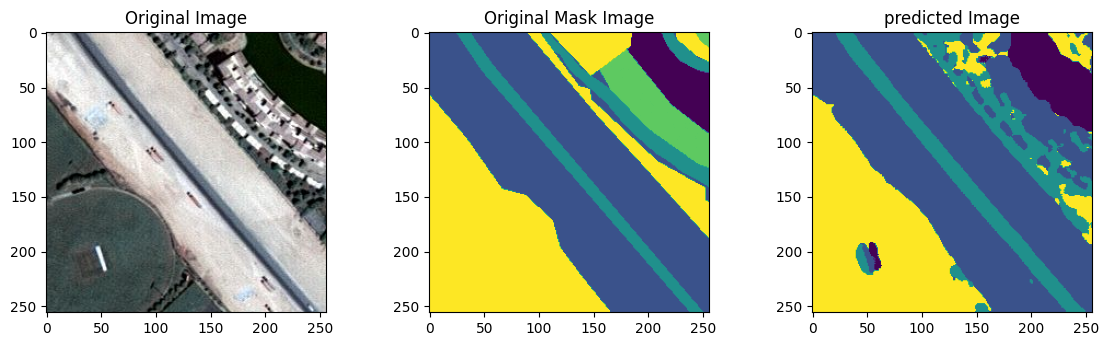

In [63]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Mask Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image)

## F. Implementasi model ke data baru

(256, 256, 3)


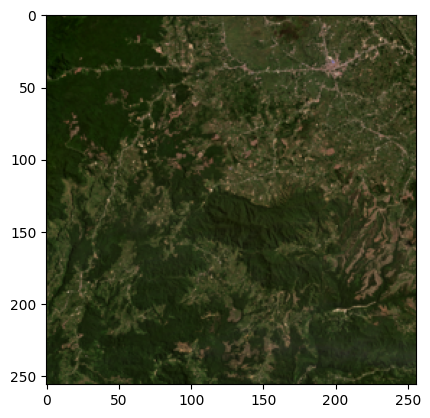

In [65]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Membaca gambar
image = Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif')

# Mereshape gambar ke (None, 256, 256, 3)
image = image.resize((256, 256))
image = np.array(image)
image_rgb = image[:, :, :3]

# Cek bentuk hasil reshape
print(image_rgb.shape)

# Menyimpan citra dalam format JPEG
output_path = 'C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.jpg'
image_jpg = Image.fromarray(image_rgb)
image_jpg.save(output_path)

# Menampilkan citra
plt.imshow(image_rgb)
plt.show()


In [66]:
image = np.expand_dims(image_rgb, 0)

In [67]:
prediction_sentinel = saved_model.predict(image)

1/1 [==============================] - 0s 394ms/step


In [68]:
predicted_image_sentinel = np.argmax(prediction_sentinel, axis=3)
predicted_image_sentinel = predicted_image_sentinel[0,:,:]

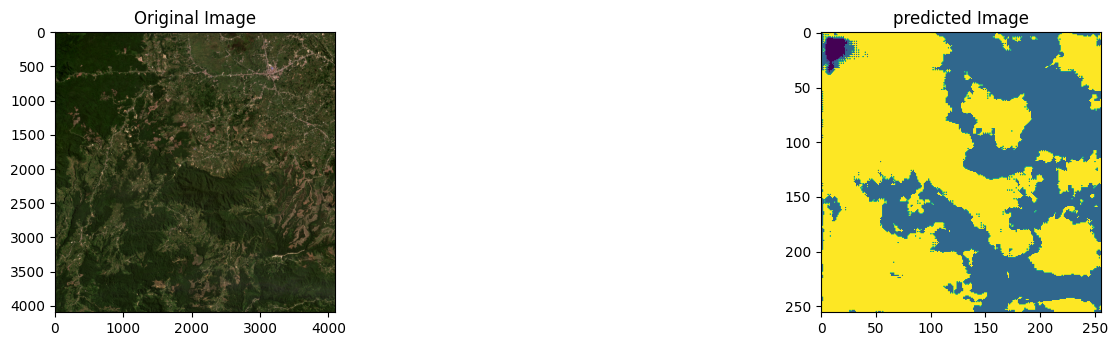

In [69]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif'))

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image_sentinel)

## Membuat activation dan heatmap

In [71]:
import keract as ke

In [72]:
activations = ke.get_activations(saved_model, image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [74]:
ke.display_activations(activations,
                       cmap='viridis',
                       save=True,
                       directory='C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

In [76]:
# Membaca gambar
image = Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif')

# Mereshape gambar ke (None, 256, 256, 3)
image = image.resize((256, 256))
image = np.array(image)
image_rgb = image[:, :, :3]
image_rgb = image_rgb.astype(np.float32)
ke.display_heatmaps(activations, image_rgb, save=True, directory='C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/heatmap')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

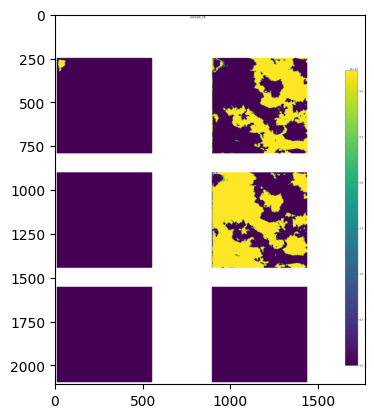

In [77]:
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/activations/40_conv2d_18.png'))

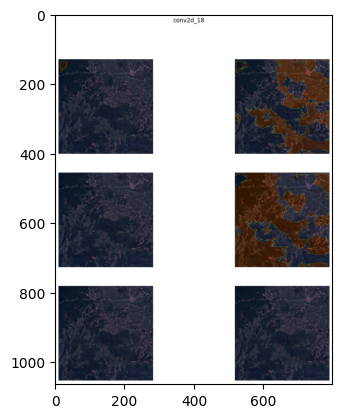

In [78]:
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/heatmap/40_conv2d_18.png'))